# Importing Required Libraries


In [1]:
import numpy as np  
import pandas as pd  
from tensorflow.keras.preprocessing.text import Tokenizer  
from tensorflow.keras.preprocessing.sequence import pad_sequences 
from sklearn.model_selection import train_test_split  
from tensorflow.keras.layers import Bidirectional, LSTM, Dense  
import tensorflow as tf  
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix  
import torch 
import matplotlib.pyplot as plt  
import seaborn as sns  
import transformers  
import json 
from tqdm import tqdm  
from torch.utils.data import Dataset, DataLoader  
from tensorflow.keras.layers import Dropout 
import logging  
from wordcloud import WordCloud
import time
import psutil
import warnings
from torch import cuda
from tabulate import tabulate
from IPython.display import Image



warnings.filterwarnings('ignore')
logging.basicConfig(level=logging.ERROR)

C:\Users\Welcome\miniconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
device = 'cuda' if cuda.is_available() else 'cpu'  # Check if GPU is available, set the device accordingly
torch.cuda.is_available()  

False

In [3]:
train_batch_size = 8  
val_batch_size = 4  
learning_rate = 1e-07  

# Loading Data

In [4]:
data = pd.read_csv('data.csv',encoding='latin-1')

In [5]:
data = data.rename(columns={'Sentence': 'Text', 'Sentiment':'Label'})

In [6]:
# Integer Encoding of sentiment values
def integer_encoding(data):
    sentiment_mapping = {
        'positive': 0,
        'negative': 1,
        'neutral': 2
    }
    data['Sentiment Encoded'] = data['Label'].map(sentiment_mapping)
    return data

# Integer Encoding of sentiment values
data = integer_encoding(data)


In [7]:
data.head(20)

,Text,Label,Sentiment Encoded
0,The GeoSolutions technology will leverage Bene...,positive,0
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative,1
2,"For the last quarter of 2010 , Componenta 's n...",positive,0
3,According to the Finnish-Russian Chamber of Co...,neutral,2
4,The Swedish buyout firm has sold its remaining...,neutral,2
5,$SPY wouldn't be surprised to see a green close,positive,0
6,Shell's $70 Billion BG Deal Meets Shareholder ...,negative,1
7,SSH COMMUNICATIONS SECURITY CORP STOCK EXCHANG...,negative,1
8,Kone 's net sales rose by some 14 % year-on-ye...,positive,0
9,The Stockmann department store will have a tot...,neutral,2


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5842 entries, 0 to 5841
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Text               5842 non-null   object
 1   Label              5842 non-null   object
 2   Sentiment Encoded  5842 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 137.0+ KB


In [9]:
# Compute the length of each text and generate descriptive statistics
data['Text'].str.len().describe()


count    5842.000000
mean      116.989730
std        56.403032
min         9.000000
25%        72.000000
50%       107.000000
75%       150.000000
max       315.000000
Name: Text, dtype: float64

# Defining Helper Functions for Preprocessing


**get_sequences(texts)**:

Defines a function that takes a list of texts as input and returns the sequences of tokenized and padded texts, along with the tokenizer object. It uses the Tokenizer class to tokenize the texts, converts the texts to sequences, and pads the sequences to a maximum length.

In [10]:
def get_sequences(texts):
    tokenizer = Tokenizer() 
    tokenizer.fit_on_texts(texts)  # Fit the tokenizer on the texts

    sequences = tokenizer.texts_to_sequences(texts)  # Convert texts to sequences
    print("Vocab length:", len(tokenizer.word_index) + 1) 

    max_seq_length = 256 
    sequences = pad_sequences(sequences, maxlen=max_seq_length, padding='post')  # Pad sequences to a maximum length
    print("Maximum sequence length:", max_seq_length)

    return sequences, tokenizer

**preprocess_inputs(df)**

The **preprocess_inputs** function takes a DataFrame as input. It creates a copy of the DataFrame to avoid modifying the original data. It then calls the **get_sequences** function to convert the text data in the **'Text'** column to sequences using a tokenizer. It defines a label mapping dictionary to replace label strings with numeric values. It applies the label mapping to the **'Label'** column of the DataFrame. It splits the sequences and corresponding labels into train and test sets using **train_test_split**. Finally, it returns the train and test sequences, labels, and the tokenizer for further processing.

In [11]:
def preprocess_inputs(df):
    df = df.copy()

    sequences, tokenizer = get_sequences(df['Text'])  # Update get_sequences function call

    label_mapping = {
        
        'positive': 0,
        'negative': 1,
        'neutral': 2,
        
    }

    y = df['Label'].replace(label_mapping)  # Replace label strings with numeric values

    train_sequences, test_sequences, y_train, y_test = train_test_split(
        sequences, y, train_size=0.8, shuffle=True, random_state=1)  

    return train_sequences, test_sequences, y_train, y_test, tokenizer

# Sentiment Proportions


This snippet calculates the count of each sentiment category in the 'Label' column of the DataFrame and sorts them in ascending order. Then, it creates a pie chart to visualize the proportion of each sentiment category, with labels showing the category names and percentages representing the proportion. The explode parameter is used to separate a slice of the pie for emphasis. Finally, it displays the chart with the title "Proportion of Sentiment."

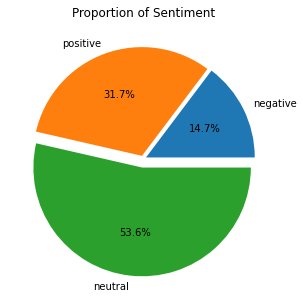

In [12]:
# Calculate sentiment proportions
x = data['Label'].value_counts().sort_values()

# Plot pie chart
plt.figure(figsize=(5, 5))
ax = plt.pie(x=x, labels=x.index, autopct='%1.1f%%', explode=[0.03, 0.03, 0.08])
plt.title('Proportion of Sentiment')
plt.show()

# Word Cloud Visualisation

Word cloud visualization is a technique used to represent text data in a visual form, where the size of each word corresponds to its frequency or importance in the given text. It creates a visual summary of the text by displaying words in different sizes and colors, with more prominent words appearing larger. This visualization technique helps to quickly identify the most frequently occurring words or the key terms within a text corpus. It is commonly used in text analysis, sentiment analysis, topic modeling, and data exploration tasks.

The code selects all the texts with a positive, negative, and neutral sentiment from the dataset. It combines them into a single string. Then, it creates a word cloud visualization using the WordCloud library, specifying the dimensions of the word cloud. Finally, it displays the word cloud image, removing the axis and adding a title. The word cloud provides a visual representation of the most frequent words in the positive, negative, and neutral sentiment texts.

# Word Cloud for Positive Sentiment


In [13]:
# If wordcloud shoes error, please install %pip install WordCloud

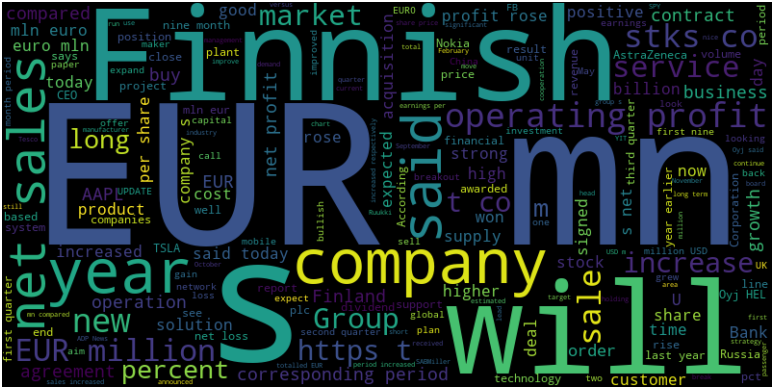

In [14]:

# Provide the image file name (with extension) located in your current Jupyter Notebook directory
image_filename = 'WordCloud Positive.PNG'

# Display the image using the Image class
Image(filename=image_filename)


# Word Cloud for Negative Sentiment


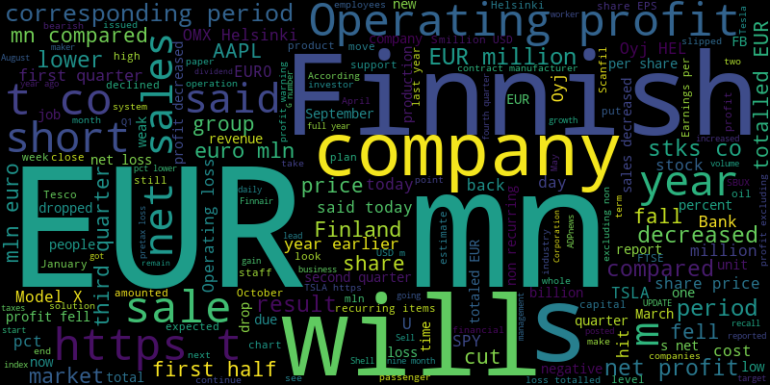

In [15]:

# Provide the image file name (with extension) located in your current Jupyter Notebook directory
image_filename = 'WordCloudNegative.PNG'

# Display the image using the Image class
Image(filename=image_filename)


# Word Cloud for Neutral Sentiment


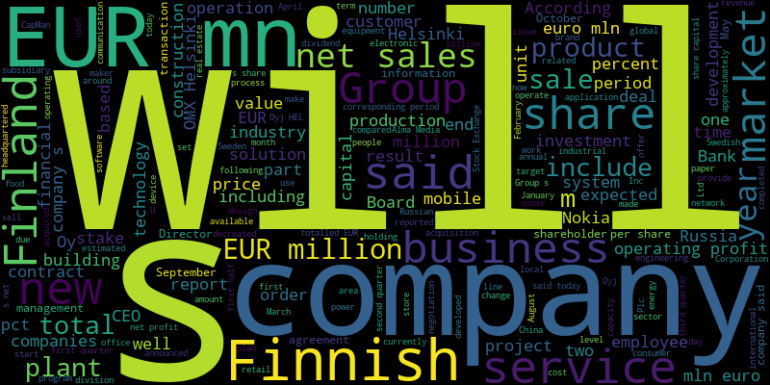

In [16]:
# Provide the image file name (with extension) located in your current Jupyter Notebook directory
image_filename = 'WordCloudNeutral.PNG'

# Display the image using the Image class
Image(filename=image_filename)


# Distribution of Text Lengths Histogram

The code plots a histogram showing the distribution of text lengths in the 'Text' column of the DataFrame 'data'. It uses the seaborn library to create the histogram plot. The x-axis represents the length of the texts, while the y-axis represents the count of texts falling into each length bin. The plot provides insights into the variation in text lengths within the dataset, helping to understand the data's characteristics and potential implications for text analysis tasks.

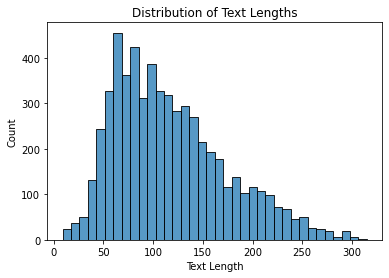

In [17]:
# Distribution of text lengths
sns.histplot(data['Text'].str.len())
plt.xlabel('Text Length')
plt.ylabel('Count')
plt.title('Distribution of Text Lengths')
plt.show()

# Preprocessing Inputs

In [18]:
train_sequences, test_sequences, y_train, y_test, tokenizer = preprocess_inputs(data)  # Update preprocess_inputs function call

Vocab length: 11505
Maximum sequence length: 256


# Model Architecture


This code defines the architecture of a neural network model using the Keras framework. It starts with an input layer specifying the shape of the input data. The input data is then passed through an embedding layer that maps each word to a dense vector representation. Next, a bidirectional LSTM layer is applied to capture contextual information from the sequences. A dropout layer is used to reduce overfitting. Finally, a dense layer with softmax activation is added to classify the sequences into one of three classes.

**Bidirectional LSTM Architecture :** The architecture of a Bidirectional LSTM (BILSTM) consists of two LSTM layers, one processing the input sequence in the forward direction and the other processing it in the backward direction. Each LSTM layer has a set of memory cells that propagate information over time, allowing the model to capture dependencies in both directions. The outputs of the forward and backward LSTMs are typically concatenated or combined in some way to obtain the final representation. This bidirectional nature helps the model capture contextual information from both past and future contexts, enabling better understanding of the input sequence. BILSTMs are commonly used in tasks such as sequence labeling, sentiment analysis, and machine translation.

**Dropout Layer :** A dropout layer is a regularization technique commonly used in neural networks to **prevent overfitting**. During training, the dropout layer randomly sets a fraction of the input units to zero at each update, which helps prevent the model from relying too heavily on specific input features. By randomly dropping out units, the dropout layer forces the network to learn more robust and generalized representations. This improves the model's ability to generalize well to unseen data and reduces the risk of overfitting.

In [19]:
inputs = tf.keras.Input(shape=(train_sequences.shape[1],))
x = tf.keras.layers.Embedding(
    input_dim=len(tokenizer.word_index) + 1,
    output_dim=128, 
    input_length=train_sequences.shape[1]
)(inputs)  # Apply embedding layer to inputs
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64))(x)  # Apply Bidirectional LSTM layer to obtain contextual representations
x = tf.keras.layers.Dropout(0.2)(x)  # Apply dropout layer to prevent overfitting
outputs = tf.keras.layers.Dense(3, activation='softmax')(x)  # Apply dense layer for classification with softmax activation



# Calculating Execution Time

The code snippet calculates the timestamp at the beginning of a process by using the time.time() function. This is typically done to measure the execution time of a specific portion of the code. It allows for monitoring and optimizing the performance of the program.

In [20]:
#Calculating the timestamp at the begining, add this right before the epoch loop
start_time = time.time()

# Model Compilation and Training

In this code, a model is created using the specified inputs and outputs. The model is then compiled with the Adam optimizer, sparse categorical crossentropy loss function, and accuracy metric. The model is trained on the training data using the fit() function, specifying the training sequences, labels, validation split, batch size, and number of epochs. The model learns patterns from the data during the training process, optimizing the specified loss function, and evaluating the accuracy. The training history is stored in the 'history' variable for further analysis and visualization.


**Epoch** : An epoch refers to a complete pass through the entire training dataset during the training of a model. During each epoch, the model's parameters are updated based on the computed loss and the chosen optimization algorithm. One epoch consists of multiple iterations, where each iteration processes a batch of samples. The number of epochs determines how many times the model will iterate over the entire training dataset

In [21]:
# Create the model with specified inputs and outputs
model = tf.keras.Model(inputs=inputs, outputs=outputs)

# Compile the model with specified optimizer, loss function, and metrics
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)

# Train the model on the training data
history = model.fit(
    train_sequences, 
    y_train,  
    validation_split=0.2, 
    batch_size=8,  # Number of samples per gradient update
    epochs=10,  
    
)    
    

Epoch 1/10
468/468 [==============================] - 115s 231ms/step - loss: 0.8515 - accuracy: 0.6217 - val_loss: 0.7301 - val_accuracy: 0.6984
Epoch 2/10
468/468 [==============================] - 109s 234ms/step - loss: 0.4891 - accuracy: 0.7937 - val_loss: 0.7146 - val_accuracy: 0.6824
Epoch 3/10
468/468 [==============================] - 101s 217ms/step - loss: 0.2577 - accuracy: 0.8842 - val_loss: 0.8273 - val_accuracy: 0.6834
Epoch 4/10
468/468 [==============================] - 114s 243ms/step - loss: 0.1794 - accuracy: 0.9029 - val_loss: 0.9655 - val_accuracy: 0.6813
Epoch 5/10
468/468 [==============================] - 117s 249ms/step - loss: 0.1447 - accuracy: 0.9195 - val_loss: 1.0989 - val_accuracy: 0.6556
Epoch 6/10
468/468 [==============================] - 117s 251ms/step - loss: 0.1409 - accuracy: 0.9254 - val_loss: 1.1838 - val_accuracy: 0.6684
Epoch 7/10
468/468 [==============================] - 121s 259ms/step - loss: 0.1243 - accuracy: 0.9243 - val_loss: 1.2962 -

# Calculating Running Time

The end time of the execution is calculated using the time.time() function. This gives the current time in seconds since the epoch. By subtracting the start time from the end time, the total runtime of the model is computed. The result is then printed, displaying the running time in seconds, minutes, and hours. The purpose of this code is to measure and report the duration it took to train or execute the Bidirectional LSTM model.

In [22]:
#Calulcate end time and total runtime of the model in seconds, write this right after the loop cell block

end_time = time.time()
running_time = end_time - start_time
print(f"Running Time of Bidirectional LSTM model: {running_time:.2f} seconds or {(running_time / 60):.2f} minutes or {(running_time / 3600):.2f} hours") 

Running Time of Bidirectional LSTM model: 1127.42 seconds or 18.79 minutes or 0.31 hours


# Calculating Memory

In [23]:
#Calculating memory usage, write this after the time calculation block mentioned above
process = psutil.Process()
memory_usage = process.memory_info().rss / 1024 / 1024  # in MB
print(f"Memory Usage of Bidirectional LSTM model: {memory_usage:.2f} MB") # Change your model here in the print statement 

Memory Usage of Bidirectional LSTM model: 509.31 MB


# Learning Curve


A learning curve in a model is a plot that shows how the model's performance (e.g., accuracy or loss) changes as the training progresses. It is a visualization of the model's learning process over multiple iterations or epochs. The learning curve typically consists of two curves: one for the training data and one for the validation data. The curve for the **training data** shows how the model's performance improves as it learns from the training examples. The curve for the **validation data** shows how well the model generalizes to unseen data. The learning curve helps in understanding the model's convergence, overfitting, or underfitting, and can provide insights into the model's performance and potential areas for improvement.

**Model Accuracy**

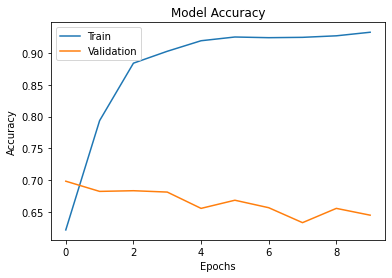

In [24]:
# Plotting the learning curve
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()



**Model Loss**

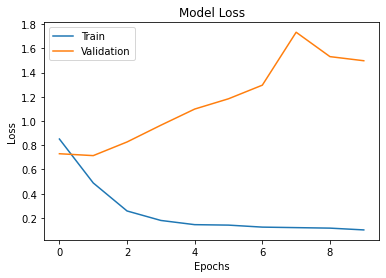

In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()



In [26]:
test_loss, test_accuracy = model.evaluate(test_sequences, y_test)
print("Test Loss: {:.4f}".format(test_loss))
print("Test Accuracy: {:.2f}%". format(test_accuracy * 100))

37/37 [==============================] - 4s 98ms/step - loss: 1.5746 - accuracy: 0.6450
Test Loss: 1.5746
Test Accuracy: 64.50%


# Perform Predictions


This snippet performs predictions using the trained model on the test sequences and obtains the predicted labels.

In [27]:
# Perform predictions
y_pred = model.predict(test_sequences)
y_pred = np.argmax(y_pred, axis=1)




37/37 [==============================] - 5s 83ms/step


# Evaluation Matrics


Evaluation metrics, such as precision, recall, and F1 score, can be calculated using different averaging methods, such as weighted and macro averaging.

**Weighted** averaging takes into account the class imbalance in the dataset. It calculates the metric for each class individually and then takes a weighted average based on the number of samples in each class. The weight assigned to each class is proportional to the number of samples in that class. Weighted averaging is suitable when there is a class imbalance in the dataset, as it gives more importance to the metrics of the minority class.

**Macro** averaging calculates the metric for each class individually and then takes the average across all classes without considering class imbalance or sample size. It treats each class equally and gives equal importance to the metrics of all classes. Macro averaging is suitable when all classes are considered equally important and there is no significant class imbalance.

In [28]:
# Compute evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
precision_macro = precision_score(y_test, y_pred, average='macro')
recall_macro = recall_score(y_test, y_pred, average='macro')
f1_macro = f1_score(y_test, y_pred, average='macro')


In [29]:

# Create a list of metric names and corresponding values
metrics = [
    ["Accuracy", "{:.2f}%".format(accuracy * 100)],
    ["Precision (Weighted)", "{:.2f}%".format(precision * 100)],
    ["Recall (Weighted)", "{:.2f}%".format(recall * 100)],
    ["F1 Score (Weighted)", "{:.2f}%".format(f1 * 100)]
]

# Print the metrics in a tabular format
print(tabulate(metrics, headers=["Metric", "Value"], tablefmt="grid"))



# If table does not show up, please install %pip install tabulate


+----------------------+---------+
| Metric               | Value   |
+======================+=========+
| Accuracy             | 64.50%  |
+----------------------+---------+
| Precision (Weighted) | 64.76%  |
+----------------------+---------+
| Recall (Weighted)    | 64.50%  |
+----------------------+---------+
| F1 Score (Weighted)  | 64.59%  |
+----------------------+---------+


**Weighted evaluation metrics**

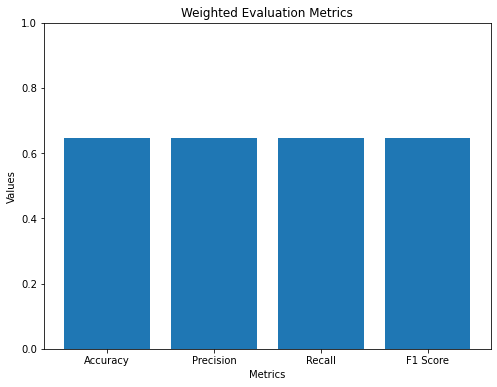

In [30]:
# Bar plot for weighted evaluation metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']  
values = [accuracy, precision, recall, f1]  
plt.figure(figsize=(8, 6)) # Create a new figure with the specified size 
plt.bar(metrics, values)  # Create a bar plot with macro metrics as x-axis and values as y-axis
plt.ylim([0, 1])  
plt.xlabel('Metrics')  
plt.ylabel('Values') 
plt.title('Weighted Evaluation Metrics')  
plt.show()  # Display the plot

In [31]:

# Create a list of metric names and corresponding values
metrics_macro = [
    ["Precision (Macro)", "{:.2f}%".format(precision_macro * 100)],
    ["Recall (Macro)", "{:.2f}%".format(recall_macro * 100)],
    ["F1 Score (Macro)", "{:.2f}%".format(f1_macro * 100)]
]

# Print the macro metrics in a tabular format
print(tabulate(metrics_macro, headers=["Metric", "Value"], tablefmt="grid"))


+-------------------+---------+
| Metric            | Value   |
+===================+=========+
| Precision (Macro) | 57.78%  |
+-------------------+---------+
| Recall (Macro)    | 57.34%  |
+-------------------+---------+
| F1 Score (Macro)  | 57.52%  |
+-------------------+---------+







**Macro evaluation metrics**

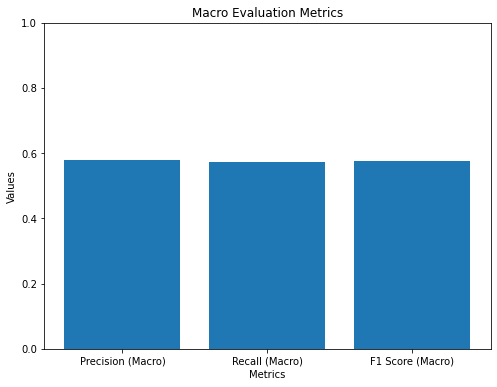

In [32]:
# Bar plot for macro evaluation metrics
metrics_macro = ['Precision (Macro)', 'Recall (Macro)', 'F1 Score (Macro)']  
values_macro = [precision_macro, recall_macro, f1_macro]  
plt.figure(figsize=(8, 6))  # Create a new figure with the specified size
plt.bar(metrics_macro, values_macro)  # Create a bar plot with macro metrics as x-axis and values as y-axis
plt.ylim([0, 1])  
plt.xlabel('Metrics')  
plt.ylabel('Values') 
plt.title('Macro Evaluation Metrics')  
plt.show()  # Display the plot

**Evaluation Matrics Class Wise**

In [33]:
# Calculate evaluation metrics for each class
class_names = ['positive', 'negative', 'neutral']
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average=None)

# Create a list of metric names and corresponding values for each class
metrics_class = []
for i, class_name in enumerate(class_names):
    metrics_class.append([
        "Class: {}".format(class_name),
        "{:.2f}%".format(precision[i] * 100),
        "{:.2f}%".format(recall[i] * 100),
        "{:.2f}%".format(f1[i] * 100)
    ])

# Print the metrics for each class in a tabular format
print(tabulate(metrics_class, headers=["Class", "Precision (Macro)", "Recall (Macro)", "F1 Score (Macro)"], tablefmt="grid"))


+-----------------+---------------------+------------------+--------------------+
| Class           | Precision (Macro)   | Recall (Macro)   | F1 Score (Macro)   |
+=================+=====================+==================+====================+
| Class: positive | 69.65%              | 64.61%           | 67.04%             |
+-----------------+---------------------+------------------+--------------------+
| Class: negative | 32.62%              | 34.27%           | 33.42%             |
+-----------------+---------------------+------------------+--------------------+
| Class: neutral  | 71.07%              | 73.14%           | 72.09%             |
+-----------------+---------------------+------------------+--------------------+


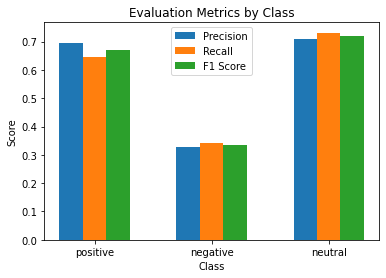

In [34]:
# Plot bar chart
x_pos = np.arange(len(class_names))

plt.bar(x_pos, precision, width=0.2, label='Precision')
plt.bar(x_pos + 0.2, recall, width=0.2, label='Recall')
plt.bar(x_pos + 0.4, f1, width=0.2, label='F1 Score')

plt.xticks(x_pos + 0.2, class_names)
plt.xlabel('Class')
plt.ylabel('Score')
plt.title('Evaluation Metrics by Class')
plt.legend()

plt.show()

# Confusion Matrix

In [35]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

In [36]:

print("Confusion Matrix:\n\n", cm)

Confusion Matrix:

 [[241  35  97]
 [ 30  61  87]
 [ 75  91 452]]


In [37]:
# Compute confusion matrix
y_pred = model.predict(test_sequences)  # Predict labels for the test sequences
y_pred = np.argmax(y_pred, axis=1)  # Convert predicted probabilities to class labels
cm = confusion_matrix(y_test, y_pred) 


37/37 [==============================] - 3s 87ms/step


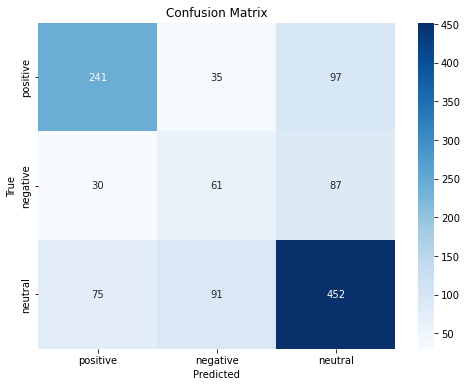

In [38]:
# Plot confusion matrix
labels = ['positive', 'negative', 'neutral'] 
plt.figure(figsize=(8, 6))  # Create a figure with specified size
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)  # Plot the confusion matrix as a heatmap with annotations
plt.xlabel('Predicted')  
plt.ylabel('True')  
plt.title('Confusion Matrix')  
plt.show()  # Display the plot


In [39]:
results = model.evaluate(test_sequences, y_test, verbose=0)  # Evaluate the model on the test data

print("    Test Loss: {:.4f}".format(results[0]))  # Print the test loss with 5 decimal places
print("Test Accuracy: {:.2f}%".format(results[1] * 100))  # Print the test accuracy as a percentage


    Test Loss: 1.5746
Test Accuracy: 64.50%
